Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [2]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from pathlib import PurePath
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

## ampis
root = '../'
sys.path.append(root)

from ampis import data_utils, visualize

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [12]:
EXPERIMENT_NAME = 'particle' # can be 'particle' or 'satellite'
json_path_train = Path(root, 'examples','powder','data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_training_W2.1.json')  # path to training data
json_path_val = Path(root,'examples','powder','data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_validation_W2.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

In [13]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['particle_Train', 'particle_Val']


## Verify images and annotations are loaded correctly
Also, this is a great time to admire my hand-drawn labels, which took sooooo long to do!
### Training Data

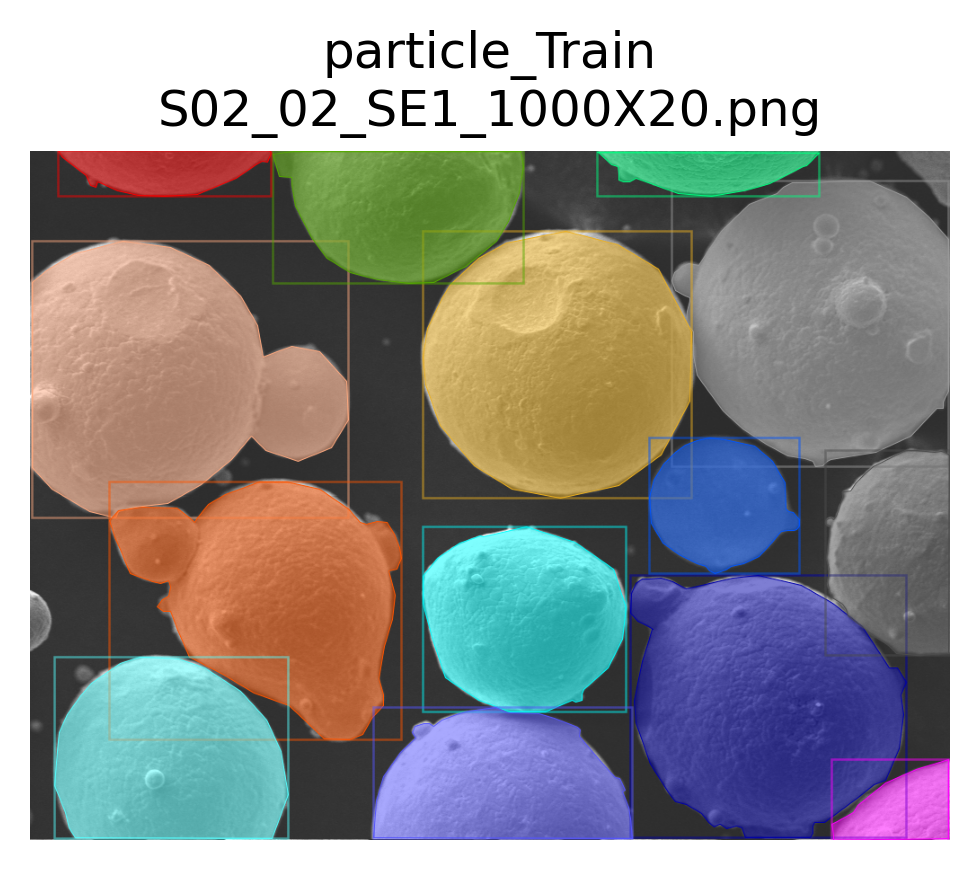

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S02_02_SE1_1000X20.png
	num_instances: 14


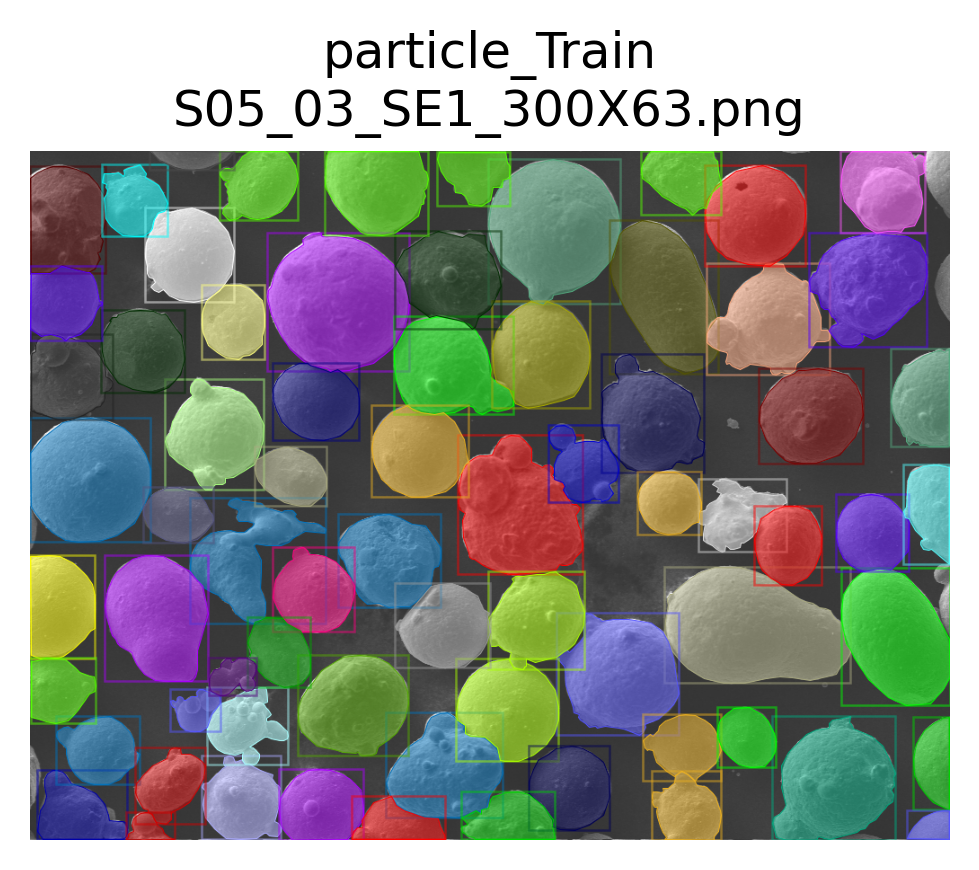

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S05_03_SE1_300X63.png
	num_instances: 71


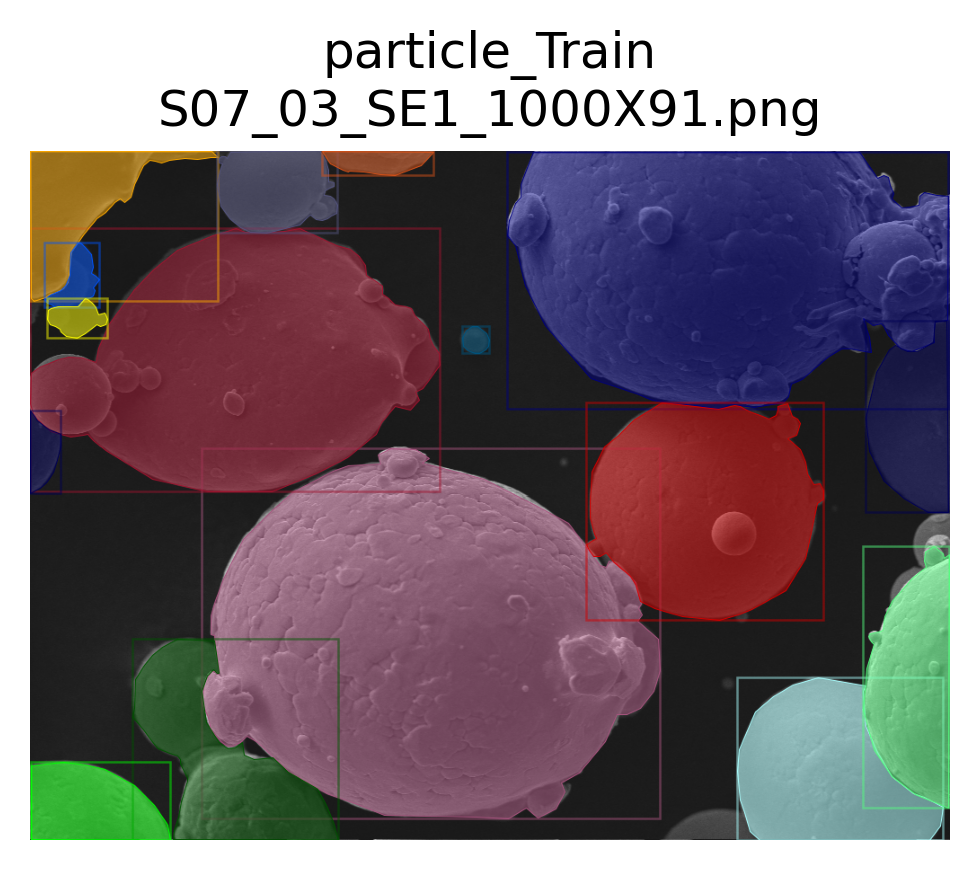

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S07_03_SE1_1000X91.png
	num_instances: 16


In [8]:
for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)

### Validation Data

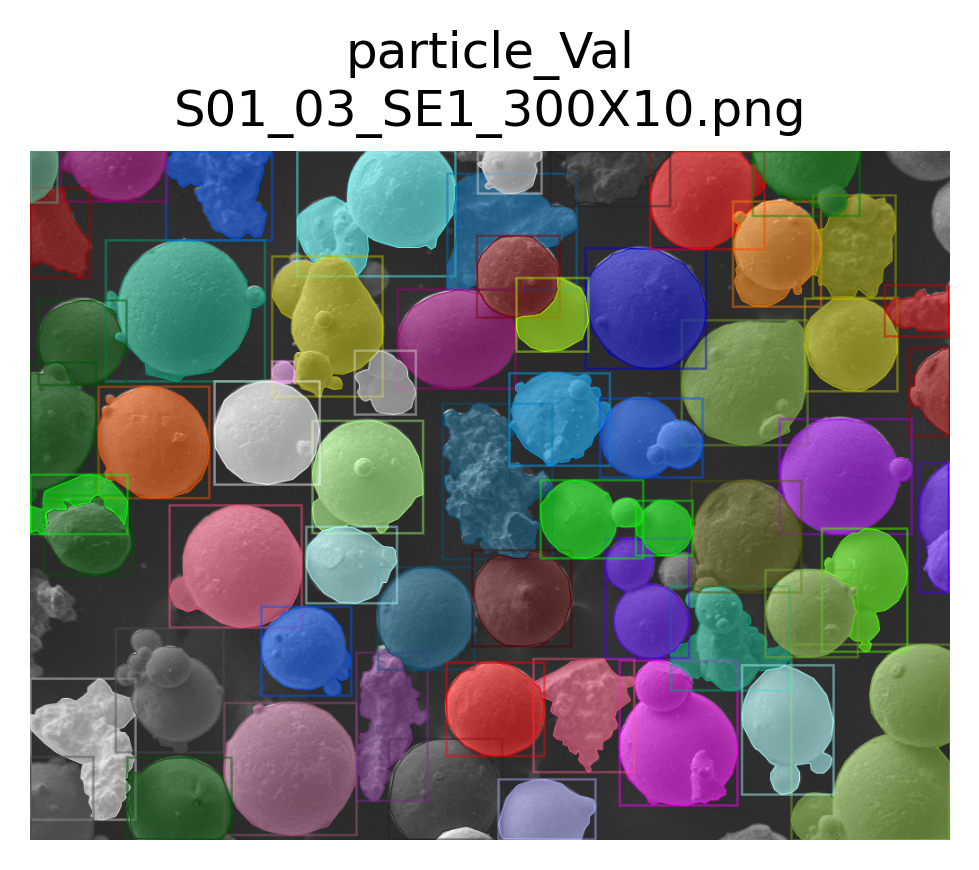

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S01_03_SE1_300X10.png
	num_instances: 61


In [9]:
for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [14]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 2500  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 5000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path(root, 'models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path(root, 'models', Path(f'{EXPERIMENT_NAME}_output_W2')))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


# Model Training
Once we have everything set up, training is very easy!

Note- this block will generate a huge wall of text.

In [15]:
trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!

[06/25 02:47:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/25 02:47:50 d2.data.build]: Removed 0 images with no usable annotations. 3 images left.
[06/25 02:47:50 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  particle  | 390          |
|            |              |
[06/25 02:47:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/25 02:47:50 d2.data.build]: Using training sampler TrainingSampler
[06/25 02:47:50 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[06/25 02:47:50 d2.data.common]: Serialized dataset takes 0.18 MiB
WARNING [06/25 02:47:50 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[06/25 02:47:50 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/25 02:47:50 d2.checkpoint.c2_model_load

[06/25 02:48:17 d2.utils.events]:  eta: 0:13:11  iter: 139  total_loss: 1.446  loss_cls: 0.2397  loss_box_reg: 0.4627  loss_mask: 0.3673  loss_rpn_cls: 0.1245  loss_rpn_loc: 0.2299  time: 0.1688  data_time: 0.0181  lr: 0.0027972  max_mem: 2953M
[06/25 02:48:21 d2.utils.events]:  eta: 0:13:09  iter: 159  total_loss: 1.547  loss_cls: 0.2708  loss_box_reg: 0.4825  loss_mask: 0.3038  loss_rpn_cls: 0.1504  loss_rpn_loc: 0.274  time: 0.1767  data_time: 0.0182  lr: 0.0031968  max_mem: 2953M
[06/25 02:48:27 d2.utils.events]:  eta: 0:13:09  iter: 179  total_loss: 1.394  loss_cls: 0.3068  loss_box_reg: 0.4736  loss_mask: 0.2514  loss_rpn_cls: 0.08025  loss_rpn_loc: 0.1896  time: 0.1873  data_time: 0.0175  lr: 0.0035964  max_mem: 2953M
[06/25 02:48:30 d2.utils.events]:  eta: 0:13:05  iter: 199  total_loss: 1.173  loss_cls: 0.2519  loss_box_reg: 0.4558  loss_mask: 0.2247  loss_rpn_cls: 0.05616  loss_rpn_loc: 0.1713  time: 0.1848  data_time: 0.0185  lr: 0.003996  max_mem: 2953M
[06/25 02:48:34 d2.u

[06/25 02:50:13 d2.utils.events]:  eta: 0:11:15  iter: 799  total_loss: 0.5946  loss_cls: 0.104  loss_box_reg: 0.2235  loss_mask: 0.08361  loss_rpn_cls: 0.03037  loss_rpn_loc: 0.1585  time: 0.1735  data_time: 0.0152  lr: 0.015984  max_mem: 2953M
[06/25 02:50:16 d2.utils.events]:  eta: 0:11:12  iter: 819  total_loss: 0.5617  loss_cls: 0.08629  loss_box_reg: 0.2335  loss_mask: 0.0814  loss_rpn_cls: 0.02416  loss_rpn_loc: 0.1635  time: 0.1734  data_time: 0.0168  lr: 0.016384  max_mem: 2953M
[06/25 02:50:20 d2.utils.events]:  eta: 0:11:09  iter: 839  total_loss: 0.5643  loss_cls: 0.1014  loss_box_reg: 0.2501  loss_mask: 0.07405  loss_rpn_cls: 0.02747  loss_rpn_loc: 0.1342  time: 0.1734  data_time: 0.0172  lr: 0.016783  max_mem: 2953M
[06/25 02:50:23 d2.utils.events]:  eta: 0:11:06  iter: 859  total_loss: 0.5442  loss_cls: 0.07512  loss_box_reg: 0.2383  loss_mask: 0.07809  loss_rpn_cls: 0.02846  loss_rpn_loc: 0.1309  time: 0.1736  data_time: 0.0171  lr: 0.017183  max_mem: 2953M
[06/25 02:50

[06/25 02:52:07 d2.utils.events]:  eta: 0:09:21  iter: 1459  total_loss: 0.3716  loss_cls: 0.07044  loss_box_reg: 0.1564  loss_mask: 0.05603  loss_rpn_cls: 0.00811  loss_rpn_loc: 0.1006  time: 0.1726  data_time: 0.0218  lr: 0.02  max_mem: 2953M
[06/25 02:52:12 d2.utils.events]:  eta: 0:09:19  iter: 1479  total_loss: 0.3534  loss_cls: 0.05711  loss_box_reg: 0.1647  loss_mask: 0.05927  loss_rpn_cls: 0.009153  loss_rpn_loc: 0.08433  time: 0.1733  data_time: 0.0183  lr: 0.02  max_mem: 2953M
[06/25 02:52:15 d2.utils.events]:  eta: 0:09:16  iter: 1499  total_loss: 0.3538  loss_cls: 0.04821  loss_box_reg: 0.1532  loss_mask: 0.05227  loss_rpn_cls: 0.009695  loss_rpn_loc: 0.0997  time: 0.1733  data_time: 0.0171  lr: 0.02  max_mem: 2953M
[06/25 02:52:19 d2.utils.events]:  eta: 0:09:13  iter: 1519  total_loss: 0.3465  loss_cls: 0.0553  loss_box_reg: 0.1381  loss_mask: 0.06035  loss_rpn_cls: 0.008059  loss_rpn_loc: 0.09183  time: 0.1733  data_time: 0.0173  lr: 0.02  max_mem: 2953M
[06/25 02:52:22 

[06/25 02:54:02 d2.utils.events]:  eta: 0:07:35  iter: 2119  total_loss: 0.2641  loss_cls: 0.05458  loss_box_reg: 0.1164  loss_mask: 0.04983  loss_rpn_cls: 0.003537  loss_rpn_loc: 0.06329  time: 0.1722  data_time: 0.0182  lr: 0.02  max_mem: 2953M
[06/25 02:54:05 d2.utils.events]:  eta: 0:07:31  iter: 2139  total_loss: 0.2692  loss_cls: 0.0418  loss_box_reg: 0.1147  loss_mask: 0.04809  loss_rpn_cls: 0.005439  loss_rpn_loc: 0.07022  time: 0.1723  data_time: 0.0180  lr: 0.02  max_mem: 2953M
[06/25 02:54:09 d2.utils.events]:  eta: 0:07:29  iter: 2159  total_loss: 0.2926  loss_cls: 0.04197  loss_box_reg: 0.1341  loss_mask: 0.04915  loss_rpn_cls: 0.004953  loss_rpn_loc: 0.07615  time: 0.1724  data_time: 0.0165  lr: 0.02  max_mem: 2953M
[06/25 02:54:12 d2.utils.events]:  eta: 0:07:25  iter: 2179  total_loss: 0.3068  loss_cls: 0.05413  loss_box_reg: 0.1403  loss_mask: 0.04994  loss_rpn_cls: 0.005118  loss_rpn_loc: 0.06907  time: 0.1723  data_time: 0.0186  lr: 0.02  max_mem: 2953M
[06/25 02:54:

[06/25 02:55:58 d2.utils.events]:  eta: 0:05:51  iter: 2779  total_loss: 0.2448  loss_cls: 0.03689  loss_box_reg: 0.1007  loss_mask: 0.04296  loss_rpn_cls: 0.004218  loss_rpn_loc: 0.06676  time: 0.1724  data_time: 0.0155  lr: 0.02  max_mem: 2953M
[06/25 02:56:03 d2.utils.events]:  eta: 0:05:49  iter: 2799  total_loss: 0.238  loss_cls: 0.02927  loss_box_reg: 0.1011  loss_mask: 0.04171  loss_rpn_cls: 0.004865  loss_rpn_loc: 0.06378  time: 0.1730  data_time: 0.0163  lr: 0.02  max_mem: 2953M
[06/25 02:56:07 d2.utils.events]:  eta: 0:05:46  iter: 2819  total_loss: 0.2397  loss_cls: 0.03524  loss_box_reg: 0.1039  loss_mask: 0.04294  loss_rpn_cls: 0.002846  loss_rpn_loc: 0.05436  time: 0.1731  data_time: 0.0171  lr: 0.02  max_mem: 2953M
[06/25 02:56:10 d2.utils.events]:  eta: 0:05:43  iter: 2839  total_loss: 0.2367  loss_cls: 0.02421  loss_box_reg: 0.1066  loss_mask: 0.04358  loss_rpn_cls: 0.005139  loss_rpn_loc: 0.05763  time: 0.1731  data_time: 0.0168  lr: 0.02  max_mem: 2953M
[06/25 02:56:

[06/25 02:57:48 d2.utils.events]:  eta: 0:04:12  iter: 3419  total_loss: 0.2068  loss_cls: 0.01645  loss_box_reg: 0.09064  loss_mask: 0.04245  loss_rpn_cls: 0.00337  loss_rpn_loc: 0.05862  time: 0.1723  data_time: 0.0206  lr: 0.02  max_mem: 2953M
[06/25 02:57:51 d2.utils.events]:  eta: 0:04:09  iter: 3439  total_loss: 0.222  loss_cls: 0.02709  loss_box_reg: 0.09766  loss_mask: 0.04216  loss_rpn_cls: 0.003179  loss_rpn_loc: 0.06168  time: 0.1722  data_time: 0.0182  lr: 0.02  max_mem: 2953M
[06/25 02:57:55 d2.utils.events]:  eta: 0:04:05  iter: 3459  total_loss: 0.1963  loss_cls: 0.01616  loss_box_reg: 0.08536  loss_mask: 0.04115  loss_rpn_cls: 0.003651  loss_rpn_loc: 0.05547  time: 0.1721  data_time: 0.0180  lr: 0.02  max_mem: 2953M
[06/25 02:57:58 d2.utils.events]:  eta: 0:04:02  iter: 3479  total_loss: 0.2179  loss_cls: 0.03066  loss_box_reg: 0.09634  loss_mask: 0.04167  loss_rpn_cls: 0.003214  loss_rpn_loc: 0.0524  time: 0.1720  data_time: 0.0183  lr: 0.02  max_mem: 2953M
[06/25 02:5

[06/25 02:59:30 d2.utils.events]:  eta: 0:02:27  iter: 4059  total_loss: 0.193  loss_cls: 0.02253  loss_box_reg: 0.0881  loss_mask: 0.03821  loss_rpn_cls: 0.002553  loss_rpn_loc: 0.04682  time: 0.1701  data_time: 0.0165  lr: 0.02  max_mem: 2953M
[06/25 02:59:33 d2.utils.events]:  eta: 0:02:24  iter: 4079  total_loss: 0.2005  loss_cls: 0.02605  loss_box_reg: 0.07975  loss_mask: 0.0394  loss_rpn_cls: 0.00264  loss_rpn_loc: 0.04715  time: 0.1701  data_time: 0.0182  lr: 0.02  max_mem: 2953M
[06/25 02:59:37 d2.utils.events]:  eta: 0:02:21  iter: 4099  total_loss: 0.2115  loss_cls: 0.02514  loss_box_reg: 0.08153  loss_mask: 0.03766  loss_rpn_cls: 0.004053  loss_rpn_loc: 0.07267  time: 0.1700  data_time: 0.0177  lr: 0.02  max_mem: 2953M
[06/25 02:59:40 d2.utils.events]:  eta: 0:02:18  iter: 4119  total_loss: 0.1824  loss_cls: 0.02034  loss_box_reg: 0.07767  loss_mask: 0.03751  loss_rpn_cls: 0.003663  loss_rpn_loc: 0.05  time: 0.1699  data_time: 0.0170  lr: 0.02  max_mem: 2953M
[06/25 02:59:43

[06/25 03:01:17 d2.utils.events]:  eta: 0:00:44  iter: 4719  total_loss: 0.179  loss_cls: 0.0222  loss_box_reg: 0.07682  loss_mask: 0.03592  loss_rpn_cls: 0.00198  loss_rpn_loc: 0.04444  time: 0.1689  data_time: 0.0195  lr: 0.02  max_mem: 2953M
[06/25 03:01:22 d2.utils.events]:  eta: 0:00:40  iter: 4739  total_loss: 0.1804  loss_cls: 0.01821  loss_box_reg: 0.08286  loss_mask: 0.0359  loss_rpn_cls: 0.002305  loss_rpn_loc: 0.04653  time: 0.1692  data_time: 0.0168  lr: 0.02  max_mem: 2953M
[06/25 03:01:27 d2.utils.events]:  eta: 0:00:37  iter: 4759  total_loss: 0.1893  loss_cls: 0.02669  loss_box_reg: 0.07642  loss_mask: 0.03767  loss_rpn_cls: 0.002465  loss_rpn_loc: 0.04766  time: 0.1695  data_time: 0.0192  lr: 0.02  max_mem: 2953M
[06/25 03:01:31 d2.utils.events]:  eta: 0:00:34  iter: 4779  total_loss: 0.1926  loss_cls: 0.01808  loss_box_reg: 0.08253  loss_mask: 0.03833  loss_rpn_cls: 0.002361  loss_rpn_loc: 0.05373  time: 0.1697  data_time: 0.0213  lr: 0.02  max_mem: 2953M
[06/25 03:01

# Visualizing model predictions
We will view the model predictions on the training and validation set.

In [16]:
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

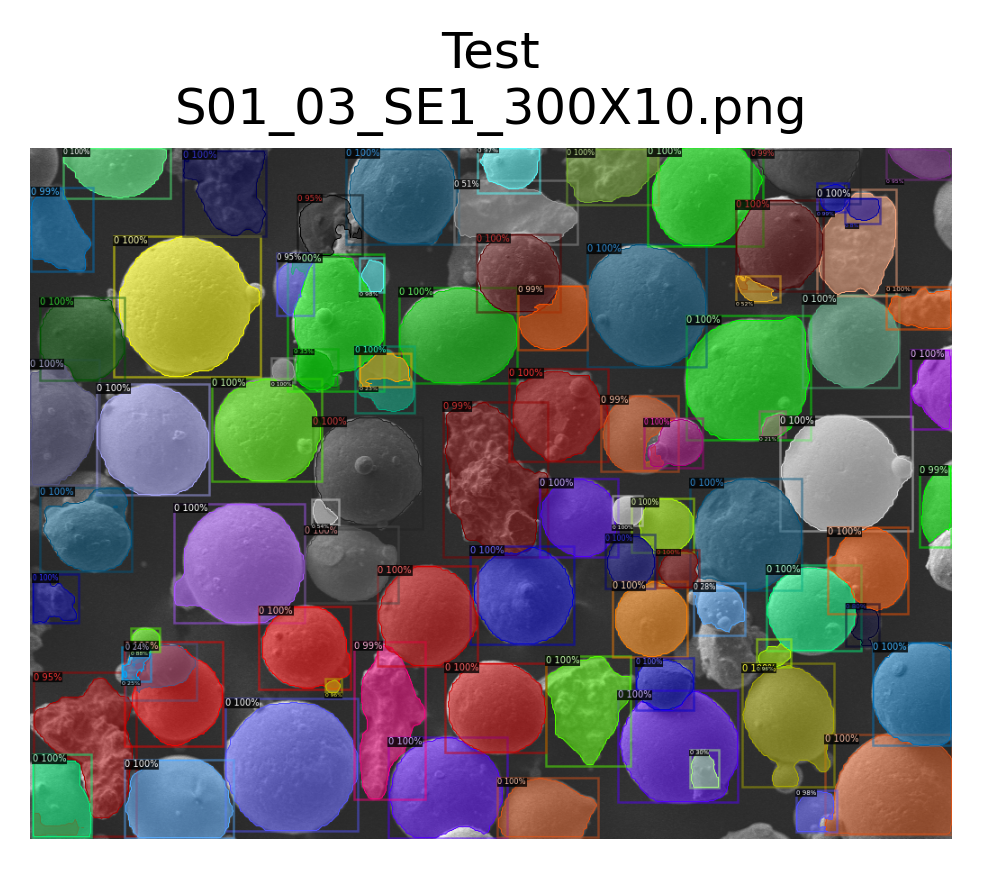

ddict info:
	path: ../examples/powder/data/images_png/S01_03_SE1_300X10.png
	num_instances: 85


In [18]:
img_path = Path(root, 'examples', 'powder', 'data','images_png','S01_03_SE1_300X10.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

Dataset: particle_Train
	File: ../examples/powder/data/via_2.0.8/../images_png/S03_01_SE1_1250X28.png


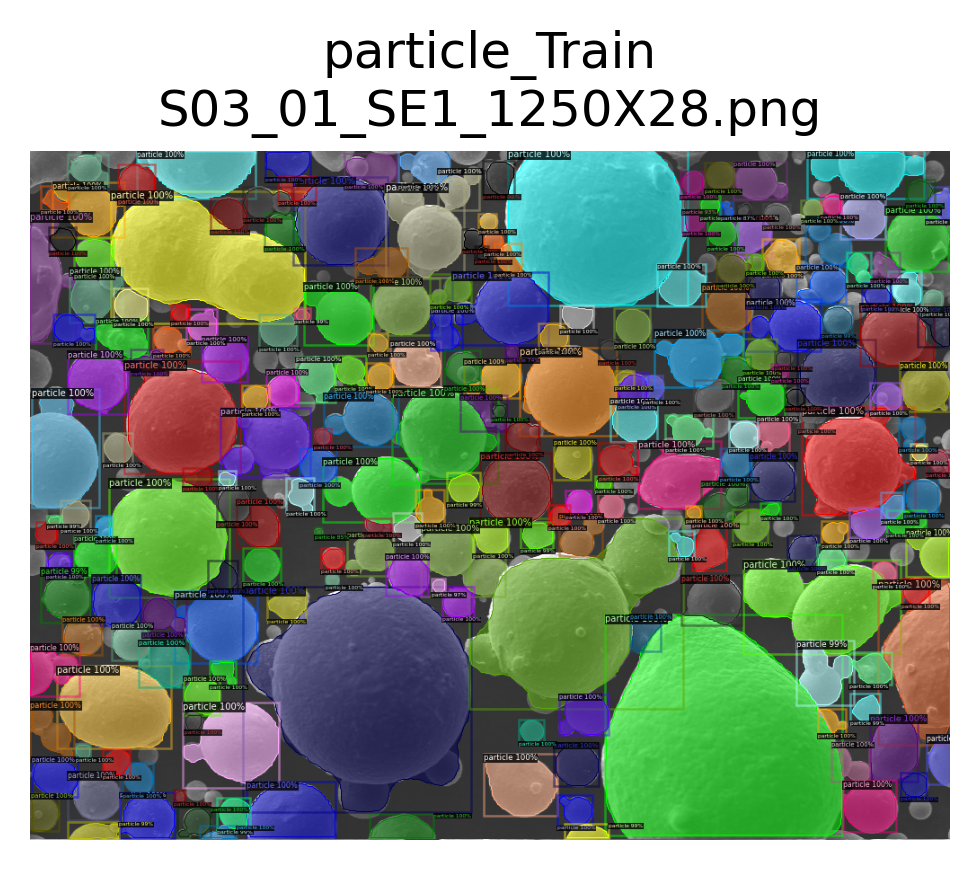

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S03_01_SE1_1250X28.png
	num_instances: 235
	File: ../examples/powder/data/via_2.0.8/../images_png/S05_01_SE1_300X56.png


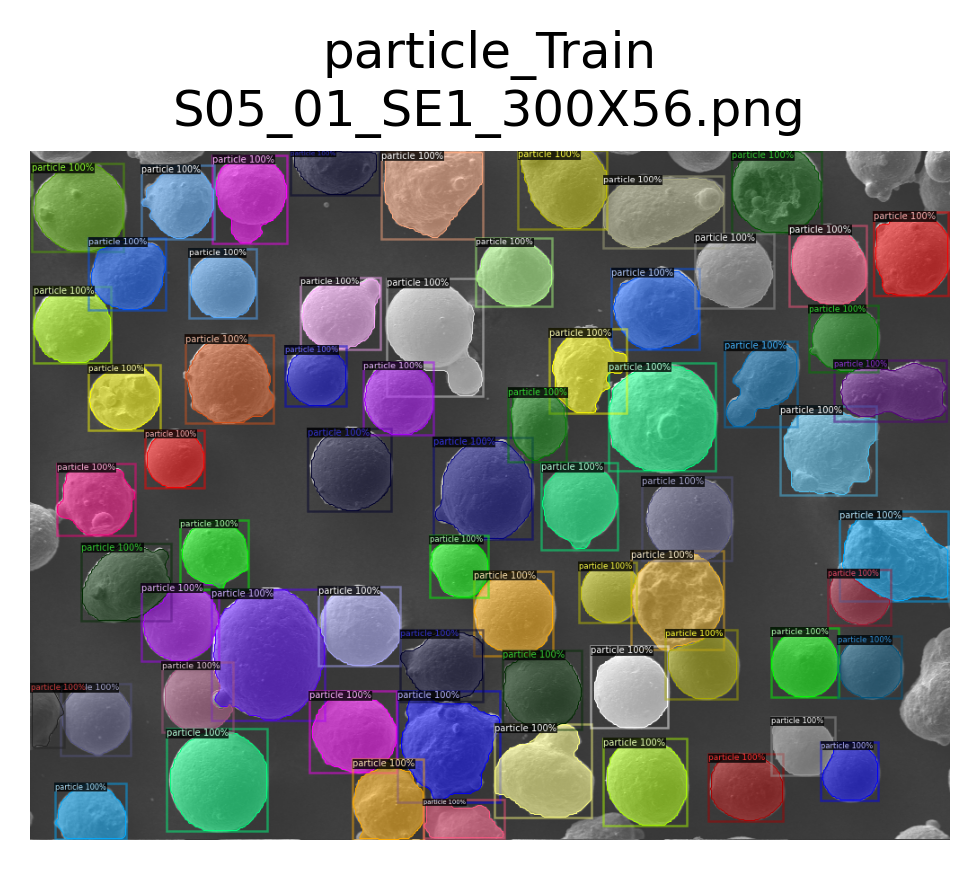

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S05_01_SE1_300X56.png
	num_instances: 66
	File: ../examples/powder/data/via_2.0.8/../images_png/S05_03_SE1_300X63.png


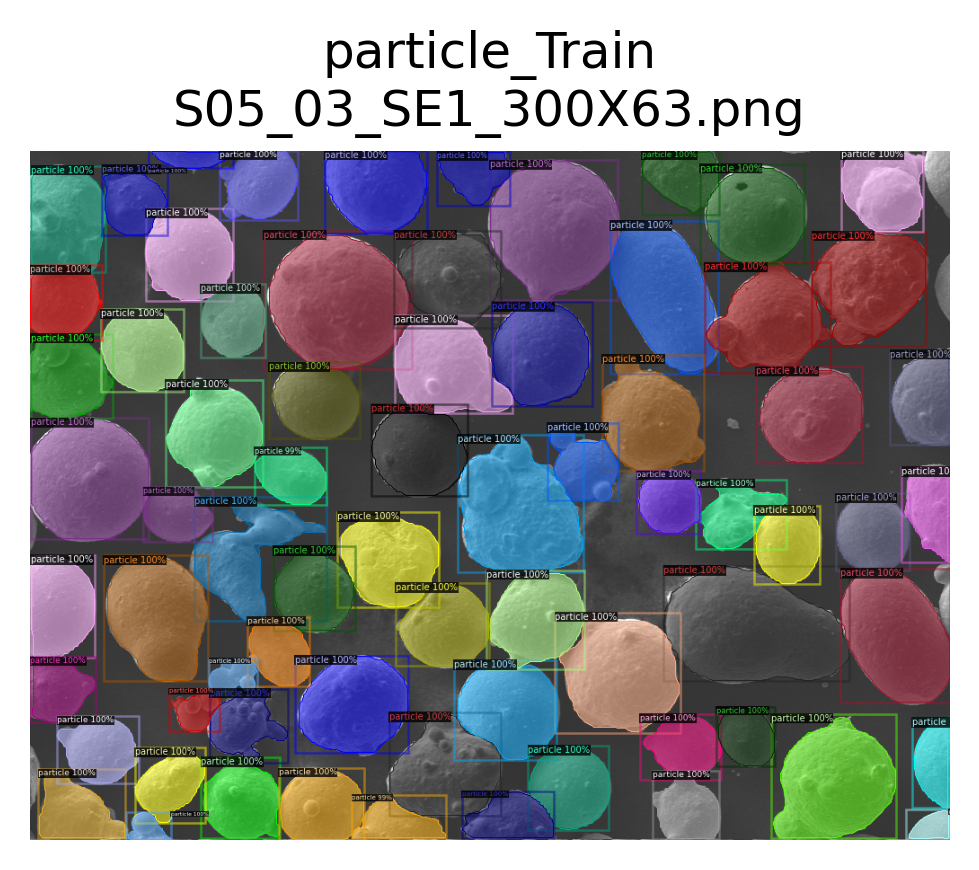

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S05_03_SE1_300X63.png
	num_instances: 71
Dataset: particle_Val
	File: ../examples/powder/data/via_2.0.8/../images_png/S01_03_SE1_300X10.png


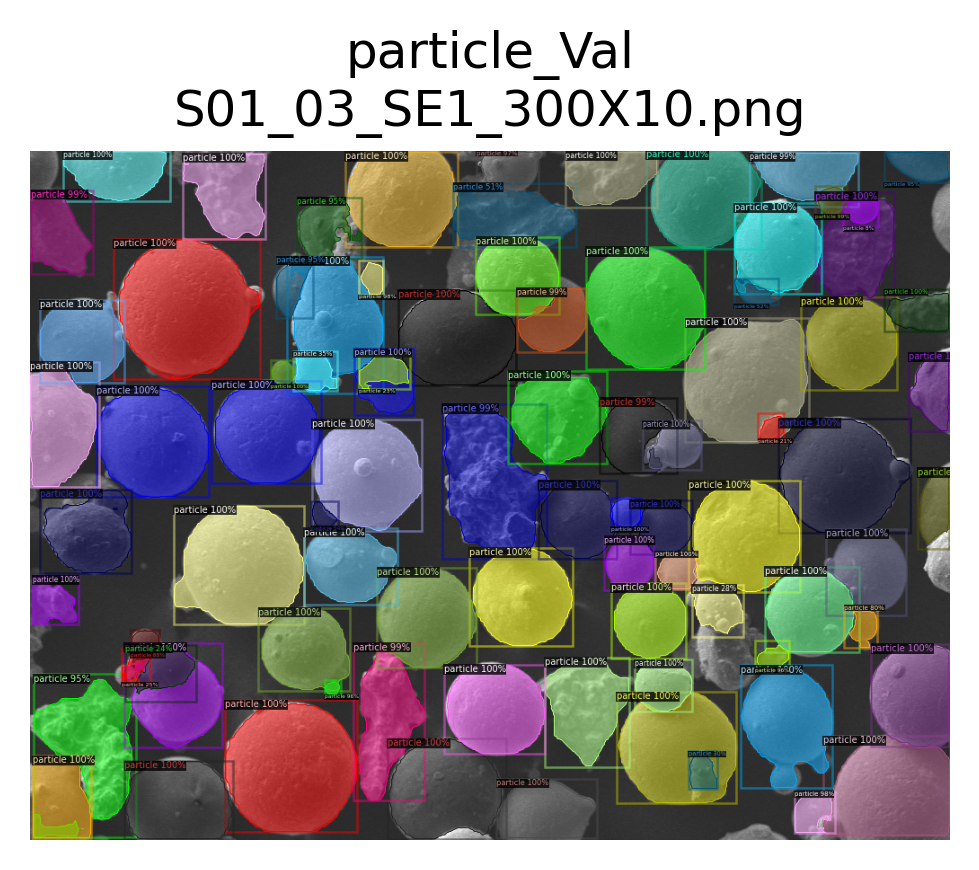

ddict info:
	path: ../examples/powder/data/via_2.0.8/../images_png/S01_03_SE1_300X10.png
	num_instances: 85


FileNotFoundError: [Errno 2] No such file or directory: 'data/particle-results_W2.pickle'

In [19]:
results = []
for ds in cfg.DATASETS.TEST:
    print(f'Dataset: {ds}')
    for dd in DatasetCatalog.get(ds):
        print(f'\tFile: {dd["file_name"]}')
        img = cv2.imread(dd['file_name'])  # load image
        outs = predictor(img)  # run inference on image
        
        # format results for visualization and store for later
        results.append(data_utils.format_outputs(dd['file_name'], ds, outs))

        # visualize results
        visualize.display_ddicts(outs, None, ds, gt=False, img_path=dd['file_name'])

# save to disk
with open(Path('data',f'{EXPERIMENT_NAME}-results_W2.pickle'), 'wb') as f:
    pickle.dump(results, f)